# I HATE this Product! Five Stars!
##### Reducing Rating Inflation Using NLP
Author: Tom Chapman

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
#from string import punctuation

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, FreqDist
from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams

#import pkg_resources

In [3]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/tom/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Understanding
The data used for training our models is a publicly-available dataset hosted by Kaggle. Users with a Kaggle account and API token already configued can execute the next cell to download the data directly. 

Users without a Kaggle account or that just want to access the data can download it from the [source page](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews?select=amazon_review_polarity_csv.tgz).

The dataset is a subset of the Stanford Network Analysis Project (SNAP), which contains approximately 34 million Amazon reviews collected over a 13 year period. Our dataset consists of 1.8 million training samples in each polarity (positive or negative) and 200,000 validation samples in each polarity. The subset was created by labelling reviews that assigned a 1-2 star rating to the negative polarity, and reviews with a 4-5 star rating to the positive polarity. Ratings that gave 3 stars were omitted entirely.

Because my goal is to train a classifier that will generalize well across different kinds of products, I chose a dataset that did not specialize in any one category. My hope is that this choice will drive greater accuracy on both Amazon reviews and reviews from other data sources.

In [4]:
# Users with a Kaggle account & API token can run this cell to download the data directly.
# import kaggle
# kaggle datasets download -d kritanjalijain/amazon-reviews

In [5]:
# Read training data & assign column names
df = pd.read_csv('../data/train.csv', names=['sentiment', 'title', 'text'])
df.head()

,sentiment,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sentiment  int64 
 1   title      object
 2   text       object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [7]:
# Check for NaNs - Unimportant because we will not use the title column.
df.isna().sum()

sentiment     0
title        77
text          0
dtype: int64

<ipython-input-35-8a54a7453d25>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = [None, 'Positive', None, None, None, None, 'Negative']);
<ipython-input-35-8a54a7453d25>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = [None, '1,000', '1,100', '1,200', '1,300', '1,400', '1,500', '1,600', '1,700', '1,800']);


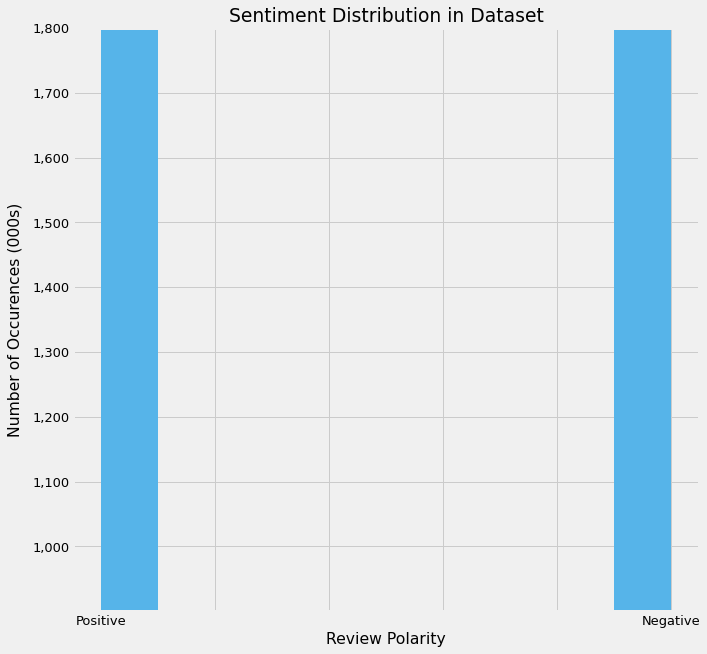

In [35]:
# Visualize sentiment frequency within the dataset

fig, ax = plt.subplots(figsize=(10,10))
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 13})
plt.axis([None, None, .9, 1.8])
plt.hist(df['sentiment'], color=[86/255,180/255,233/255])
ax.set_title('Sentiment Distribution in Dataset')
ax.set_ylabel('Number of Occurences (000s)',labelpad=10)
ax.set_xlabel('Review Polarity')
ax.set_xticklabels(labels = [None, 'Positive', None, None, None, None, 'Negative']);
ax.set_yticklabels(labels = [None, '1,000', '1,100', '1,200', '1,300', '1,400', '1,500', '1,600', '1,700', '1,800']);
plt.savefig('../images/sent_dist.png', dpi=500, facecolor='auto')

As expected, the data is near-perfectly distributed between the two sentiment classes.

# Data Preprocessing

Preprocessing is a critical piece of any NLP project.  They appear in order below, and perform the following tasks:

**get_wordnet_pos** -- Translates the part of speech tags assigned by nltk into wordnet tags that can be utilized by the lemmatizer.

**prepare_text** -- Main cleaner function. Performs the following tasks:
- Performs tokenization using a defined regular expression. By default the expression is words of any length that start with a capital or lowercase letter, and end with a lowercase letter.
- Converts all text to lowercase.
- Removes stopwords.
- Performs part of speech tagging and lemmatizes words.
- Returns a string of tokens.

**ngram_creator** -- Creates a list of tuples containing all possible n-grams in a text, where n is specified at runtime.

**visualize_top_n** -- Creates a dictionary of the n most common words in a FrequencyDistribution object, and plots a bar graph of their frequency.

**sw_finder** -- Returns a list of common words between two FrequencyDistribution Objects

## Helper Functions
Given the large size of the dataset, I created several helper functions to facilitate efficient text cleaning outside of the model pipelines prepared in the [modeling notebook](modeling_nb.ipynb).

In [8]:
# POS-Tag Translator

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk part of speech tags to wordnet tags that can be used by the lemmatizer.
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [9]:
# Text Cleaner Function

def prepare_text(text, sw=stopwords.words('english'), regex_pattern = "([a-zA-Z]+(?:'[a-z]+)?)"):
    """
    Tokenize, standardize case, remove punctuation, perform part of speech tagging
    and lemmatize text from string.
    
    By default, tokenization is performed using a regular expression that grabs words 
    that begin with a capital or lowercase letter and end with a lowercase letter.
    """
        
    # Tokenize words based on the regular expression stored in regex_pattern
    tokenizer = RegexpTokenizer(regex_pattern)
    tokens = tokenizer.tokenize(text)
    
    # Convert tokens to lowercase and remove words in the stop_list variable
    tokens = [token.lower() for token in tokens if token.lower() not in sw]
    
    # Perform part of speech tagging
    tokens_tagged = pos_tag(tokens)
    tokens_tagged = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]
    
    # Perform lemmatization 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word[0], word[1]) for word in tokens_tagged]
    
    # Return a string consisting of all tokens
    return ' '.join(tokens)

In [10]:
# Function to convert prepared text into n-grams.

def ngram_creator(text, n):
    """
    Return a list of all possible n-grams from the specified text.
    """
    return list(ngrams(text.split(), n))

In [11]:
# Visualization Function to plot the n most common words in a frequency distribution object

def visualize_top_n(freq_dist, title, n=10):
    """
    Create a dictionary of the n most common words in a frequency distribution and plot a bar
    graph illustrating how many times those words appear in the frequency distribution object.
    """
    plt.style.use('fivethirtyeight')
    plt.rcParams.update({'font.size': 13})
        
    # Extract data for plotting
    top_n = list(zip(*freq_dist.most_common(n)))
    tokens = top_n[0]
    counts = top_n[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    plt.tight_layout()
    
    # Save png of image to images folder using title as filename
    plt.savefig(f'../images/{title}', dpi=500)

In [12]:
# Function to identify common words in positive, negative reviews.

def sw_finder(fd1, fd2, n=10):
    """
    Intake two frequency distribution objects and return a list of n words
    that appear in both objects.
    """
    return list(dict(fd1.most_common(n)).keys() & dict(fd2.most_common(n)).keys())

## Data Cleaning
I began the cleaning process by testing the cleaner function on a single cell. It appears to be working correctly, so I moved on to create a new column called 'text_cleaned' to hold the results of the cleaning function. I then called the ngram_creator function on that cleaned text to create new columns that store bi-grams and tri-grams for each review. Finally, I checked for any instances of failure by the cleaning function to determine whether additional steps were needed. As it turned out, the cleaning function performed well and there were no instances of missing cleaned reviews.

In [13]:
# Test cleaner function on one row
sample_row = prepare_text(df['text'][0])
print(sample_row)

# Print original text for inspection
df['text'][0]

sound track beautiful paint senery mind well would recomend even people hate vid game music play game chrono cross game ever play best music back away crude keyboarding take fresh step grate guitar soulful orchestra would impress anyone care listen


'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [14]:
# Apply helper function to 'text' column and store the output in a new column
df['text_cleaned'] = df['text'].apply(prepare_text)

# Create & store bi-grams in a new column
df['bigrams'] = df['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df['trigrams'] = df['text_cleaned'].apply(ngram_creator, n=3)

In [15]:
# Check for reviews where the cleaning function failed & display them
print(df.isna().sum())
df[df['text_cleaned'].isna()]

sentiment        0
title           77
text             0
text_cleaned     0
bigrams          0
trigrams         0
dtype: int64


,sentiment,title,text,text_cleaned,bigrams,trigrams


In [16]:
# Create new dataframe with cleaned text, sentiment and n-grams, save to csv.
df.to_csv('../data/train_cleaned.csv', columns=['sentiment', 'text', 'text_cleaned', 'bigrams', 'trigrams'])

In [19]:
# Display the first five rows for visual inspection
df.head()

,sentiment,title,text,text_cleaned,bigrams,trigrams
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,sound track beautiful paint senery mind well w...,"[(sound, track), (track, beautiful), (beautifu...","[(sound, track, beautiful), (track, beautiful,..."
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,i'm reading lot review say best game soundtrac...,"[(i'm, reading), (reading, lot), (lot, review)...","[(i'm, reading, lot), (reading, lot, review), ..."
2,2,Amazing!,This soundtrack is my favorite music of all ti...,soundtrack favorite music time hand intense sa...,"[(soundtrack, favorite), (favorite, music), (m...","[(soundtrack, favorite, music), (favorite, mus..."
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,truly like soundtrack enjoy video game music p...,"[(truly, like), (like, soundtrack), (soundtrac...","[(truly, like, soundtrack), (like, soundtrack,..."
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",played game know divine music every single son...,"[(played, game), (game, know), (know, divine),...","[(played, game, know), (game, know, divine), (..."


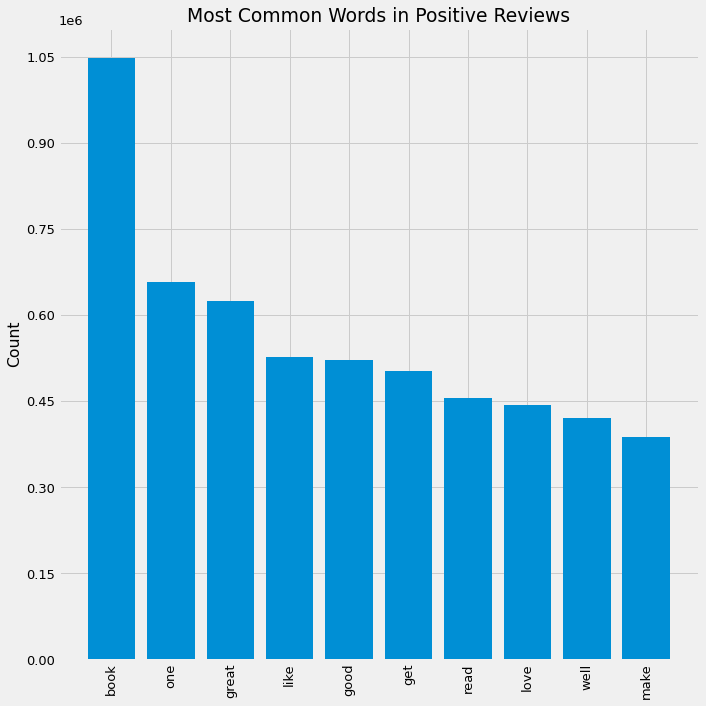

In [20]:
# Ten most common words appearing in positive reviews
pos_freq_dist = FreqDist(df['text_cleaned'].str.split().explode().loc[df['sentiment'] == 2])
visualize_top_n(pos_freq_dist, 'Most Common Words in Positive Reviews', 10)

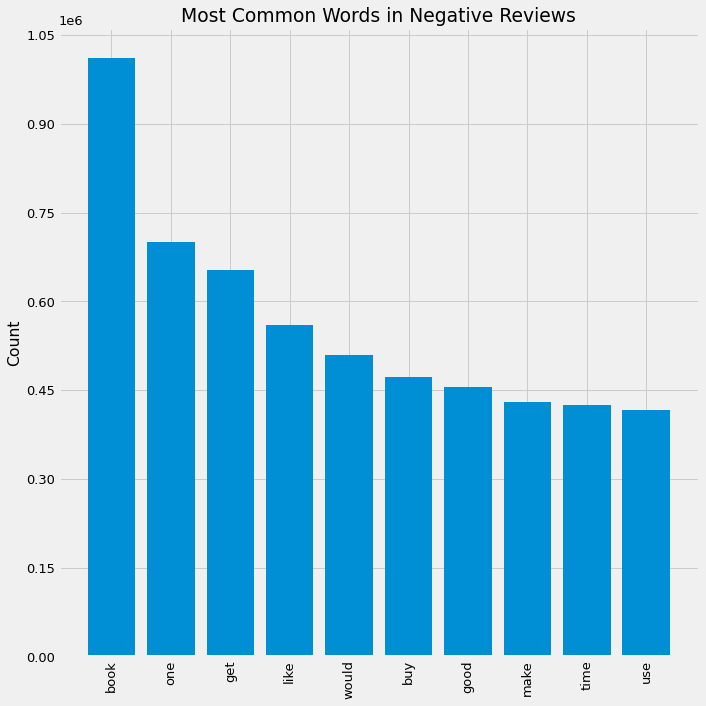

In [21]:
# Ten most common words appearing in negative reviews
neg_freq_dist = FreqDist(df['text_cleaned'].str.split().explode().loc[df['sentiment'] == 1])
visualize_top_n(neg_freq_dist, 'Most Common Words in Negative Reviews', 10)

### Identify and Remove Custom Stopwords
The following section will be focused on identifying the most common words in reviews of each sentiment, and finding where these lists intersect. Words that appear frequently in both sentiments begin to lose their meaning, and we will attempt to address this by removing any words that are among the 10 most common in both sentiments. I chose 10 words as the cutoff because there seems to be a breakpoint at 10 words where the same words do not appear in both lists and are not ordered the same in terms of commonality. I created a custom stopwords list using the sw_finder function and extended the default stopwords list to include these common words. I then re-ran the cleaning function and saved the results to a .csv for use in the modeling notebook.

In [22]:
# Identify common words among the 10 most frequent words in reviews of each sentiment
train_sw = sw_finder(neg_freq_dist, pos_freq_dist, 10)
train_sw

['one', 'make', 'good', 'get', 'book', 'like']

In [25]:
# Extend stop_list to include the elements of custom_sw
train_sw.extend(stopwords.words('english'))
train_sw

In [32]:
# Apply helper function to 'text' column and store the output in a new column
df['text_cleaned'] = df['text'].apply(prepare_text, train_sw)

# Create & store bi-grams in a new column
df['bigrams'] = df['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df['trigrams'] = df['text_cleaned'].apply(ngram_creator, n=3)

In [33]:
# Identify reviews where the cleaning function failed & display them
print(df.isna().sum())
df[df['text_cleaned'].isna()]

sentiment        0
title           77
text             0
text_cleaned     0
bigrams          0
trigrams         0
dtype: int64


,sentiment,title,text,text_cleaned,bigrams,trigrams


In [34]:
# Create new dataframe with cleaned text and sentiment, save to csv.
df.to_csv('../data/train_cleaned_10sw.csv', columns=['sentiment', 'text', 'text_cleaned', 'bigrams', 'trigrams'])

## Transform Test Data
For the test data, I followed the same cleaning process and utilized the same functions as on the train data. Although the specific stop words might vary, I followed the same procedure with custom words and removed any words that appeared in the 10 most common words in each sentiment. I saved off .csv files with and without the use of custom stopword filtering to see which will perform better in the [modeling notebook](modeling_nb.ipynb).

In [35]:
# Read in valdiation data
df_test = pd.read_csv('../data/test.csv', names=['sentiment', 'title', 'text']) 
df_test.head()

,sentiment,title,text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [36]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  400000 non-null  int64 
 1   title      399990 non-null  object
 2   text       400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


In [37]:
# Check for NaNs - Unimportant because we will not use the title column.
df_test.isna().sum()

sentiment     0
title        10
text          0
dtype: int64

In [39]:
# Apply cleaning function to the validation set
df_test['text_cleaned'] = df_test['text'].apply(prepare_text)

# Create & store trigrams in a new column
df_test['bigrams'] = df_test['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df_test['trigrams'] = df_test['text_cleaned'].apply(ngram_creator, n=3)

In [40]:
df_test.head()

,sentiment,title,text,text_cleaned,bigrams,trigrams
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,lovely pat one great voice generation listen c...,"[(lovely, pat), (pat, one), (one, great), (gre...","[(lovely, pat, one), (pat, one, great), (one, ..."
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,despite fact play small portion game music hea...,"[(despite, fact), (fact, play), (play, small),...","[(despite, fact, play), (fact, play, small), (..."
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,bought charger jul work ok design nice conveni...,"[(bought, charger), (charger, jul), (jul, work...","[(bought, charger, jul), (charger, jul, work),..."
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,check maha energy's website powerex mh c f cha...,"[(check, maha), (maha, energy's), (energy's, w...","[(check, maha, energy's), (maha, energy's, web..."
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,review quite bit combo player hesitant due unf...,"[(review, quite), (quite, bit), (bit, combo), ...","[(review, quite, bit), (quite, bit, combo), (b..."


In [41]:
# Identify reviews where the cleaning function failed & display them
print(df_test.isna().sum())
df_test[df_test['text_cleaned'].isna()]

sentiment        0
title           10
text             0
text_cleaned     0
bigrams          0
trigrams         0
dtype: int64


,sentiment,title,text,text_cleaned,bigrams,trigrams


In [42]:
# Save validation data to a new CSV file
df_test.to_csv('../data/test_cleaned.csv', columns=['sentiment', 'text', 'text_cleaned', 'bigrams', 'trigrams'])

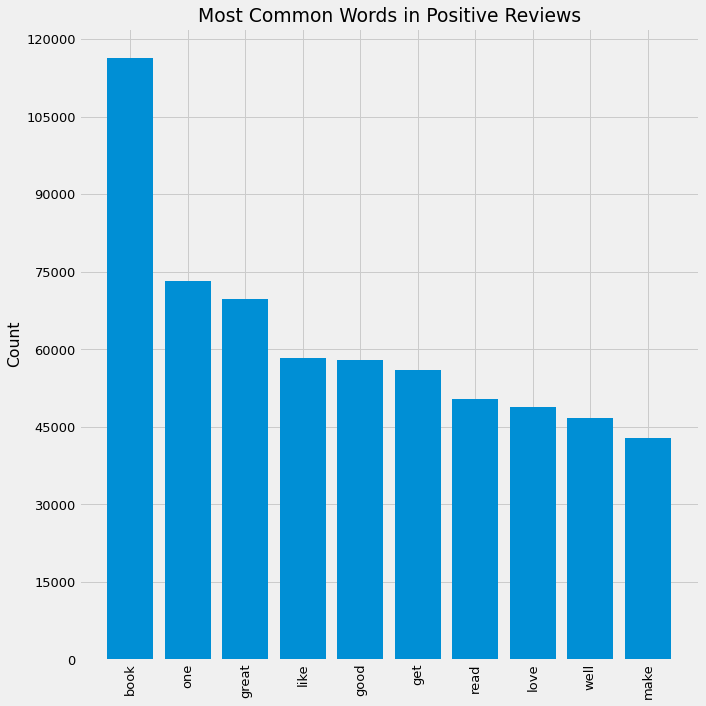

In [43]:
# Ten most common words appearing in positive test reviews
pos_test_dist = FreqDist(df_test['text_cleaned'].str.split().explode().loc[df_test['sentiment'] == 2])
visualize_top_n(pos_test_dist, 'Most Common Words in Positive Reviews', 10)

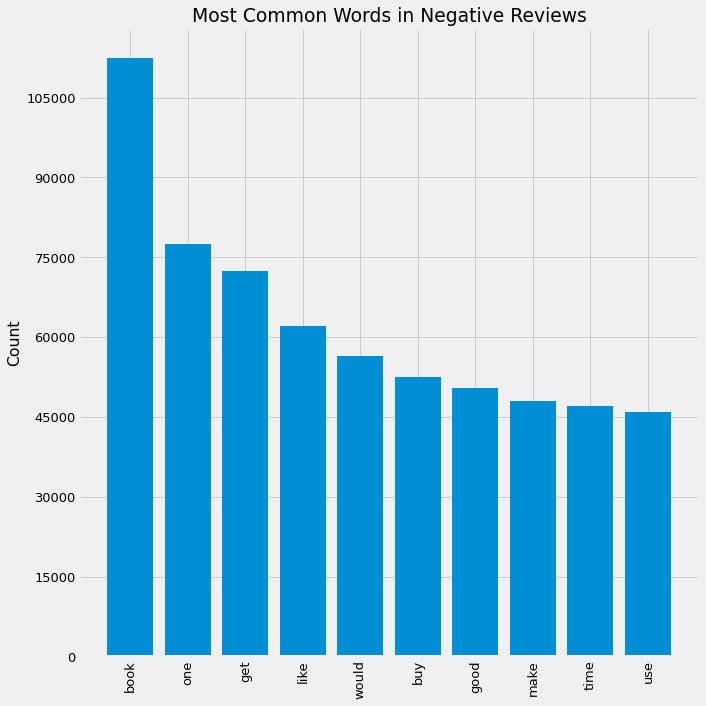

In [44]:
# Ten most common words appearing in negative reviews
neg_test_dist = FreqDist(df_test['text_cleaned'].str.split().explode().loc[df_test['sentiment'] == 1])
visualize_top_n(neg_test_dist, 'Most Common Words in Negative Reviews', 10)

In [45]:
# Identify common words among the 10 most frequent words in reviews of each sentiment
test_sw = sw_finder(neg_test_dist, pos_test_dist, 10)
test_sw

['one', 'make', 'good', 'get', 'book', 'like']

In [46]:
# Extend test_sw to include custom stop words from test data.
test_sw.extend(stopwords.words("english")) 
test_sw

['one',
 'make',
 'good',
 'get',
 'book',
 'like',
 'i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'whe

In [47]:
# Re-apply cleaning function to 'text' column using identified stopwords 
df_test['text_cleaned'] = df_test['text'].apply(prepare_text, sw=test_sw)

# Create & store bi-grams in a new column
df_test['bigrams'] = df_test['text_cleaned'].apply(ngram_creator, n=2)

# Create & store trigrams in a new column
df_test['trigrams'] = df_test['text_cleaned'].apply(ngram_creator, n=3)

In [48]:
# Identify reviews where the cleaning function failed & display them
print(df_test.isna().sum())
df_test[df_test['text_cleaned'].isna()]

sentiment        0
title           10
text             0
text_cleaned     0
bigrams          0
trigrams         0
dtype: int64


,sentiment,title,text,text_cleaned,bigrams,trigrams


In [49]:
# Create new dataframe with cleaned text inclusive of custom sw and sentiment, save to csv.
df_test.to_csv('../data/test_cleaned_10sw.csv', columns=['sentiment', 'text', 'text_cleaned', 'bigrams', 'trigrams'])